In [ ]:
import pathlib

# wiki, version, langcode = 'simplewiki', '20211120', 'en'
# wiki, version, langcode = 'tawiki', '20220301', 'ta'
# wiki, version, langcode = 'fawiki', '20220301', 'fa'
# wiki, version, langcode = 'trwiki', '20220301', 'tr'
wiki, version, langcode = 'nlwiki', '20220301', 'nl'
# wiki, version, langcode = 'arwiki', '20220301', 'ar'
# wiki, version, langcode = 'srwiki', '20220301', 'sr'
# wiki, version, langcode = 'eswiki', '20220301', 'es'

fpreds = sorted(pathlib.Path(f'wiki/{wiki}-{version}/experiments/').glob('*.tsv'))
fgold = pathlib.Path(f'evaluation/Mewsli-9/{langcode}.tsv')

from minimel import evaluate
df = evaluate(fgold, *fpreds)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:06<00:00,  8.52it/s]


In [ ]:
import pandas as pd

abl = pd.Series(df.index).str.extract(
    'pred-mewsli.'
    '(?P<kind>\w+)'
    '-?(?P<q>q0.25|q0.5|q1)?'
    '(?P<f>.feat-clean-q1\.p[.0-9]+?)?'
    '(?P<b>.\d+b)?'
    '(?P<c>\..*?)?$'
)
abl['c'] = abl['c'].fillna('')
abl['c'] = abl.apply(lambda s: (s['c']!='') if s['kind']!='base' else s['c'], axis=1)
abl['b'] = abl['b'].str[1:-1].astype('float').astype('Int32')
abl['f'] = abl['f'].fillna('')


f1 = df.set_index(pd.MultiIndex.from_frame(abl))[('micro','fscore')].rename('f1')

usefeats = False
f = (f1.index.get_level_values('f')!='') if usefeats else (f1.index.get_level_values('f')=='')
f1 = f1[(f1.index.get_level_values('kind')=='base') | f]
f1 = f1.droplevel('f')
f1

kind   q      b    c             
base   NaN    NaN  .clean-q1         0.768122
                   .clean-stem-q1    0.773224
                                     0.625066
clean  q0.25  16   True              0.731447
                   False             0.679270
              20   True              0.768200
                   False             0.716023
              24   True              0.781509
                   False             0.729332
              28   True              0.784417
                   False             0.732240
              32   True              0.785123
                   False             0.732946
       q0.5   16   True              0.704125
                   False             0.679535
              20   True              0.759298
                   False             0.734708
              24   True              0.778424
                   False             0.753834
              28   True              0.782478
                   False             0.757888


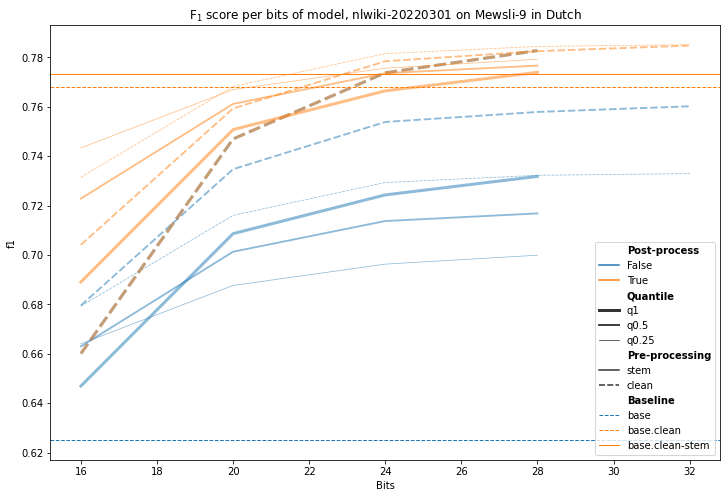

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

data = f1[f1.index.drop(['base'])].reset_index().rename(columns={
    'c': 'Post-process',
    'q': 'Quantile',
    'b': 'Bits',
    'kind': 'Pre-processing',
})[::-1]

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(
    data=data, 
    x='Bits', y='f1', hue='Post-process', style='Pre-processing', size='Quantile',
    alpha=.5,
    ax=ax)

handles, labels = ax.get_legend_handles_labels()
handles.append( handles[0] ), labels.append('Baseline')
for (_,_,c), basef1 in f1.loc['base'].sort_index().iteritems():
    ls = '-' if 'stem' in c else '--'
    color = 'C1' if c else 'C0'
    label = f'base{c[:-3]}'
    handles.append( ax.axhline(basef1, ls=ls, linewidth=1, color=color, label=label) )
    labels.append(label)

legend = plt.legend(handles=handles, labels=labels)
for h, text in zip(handles, legend.get_texts()):
    if not h.get_visible():
        text.set_fontweight('bold')
    
from minimel import code_name
langname = code_name.get(langcode).title()
plt.title(f'F$_1$ score per bits of model, {wiki}-{version} on Mewsli-9 in {langname}')
None